### Financial Index Prediction
This notebook seeks to predict if an ARMA model predicts a higher or lower price than the actual outcome. News from day $k$ are used to evaluate the outcome on day $k$. A range of different combinations between statistical and NLP-models are used. 

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.utils import parallel_backend
from pathlib import Path
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Embedding, Lambda, LSTM, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from tqdm import tqdm, trange

#### Load financial news data and financial index data

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
# Read from 2006-10-20 for next day preds or from 2006-10-19 for current day preds
fin_data = fin_data.loc['2006-10-20' : '2013-11-22']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

In [3]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
        
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for date in valid_dates: 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.loc[date]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.loc[date]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.loc[date]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.loc[date]

In [4]:
def format_word(word): 
    """ A method for formatting words to be more similar to those in the 
    pre-trained glove embeddings. For example, won't -> will not, removing 's etc. 
    """
    if word == "n't":
        return "not"
    if word == "'s": 
        return ""
    if word == "wo":
        return "will"
    if len(word) > 1 and word[0] == "'":
        return word[1:]
    return word

In [5]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for date in tqdm(valid_dates): 
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        words = word_tokenize(text.lower())
        for j,word in enumerate(words): 
            if j < len(words) - 1:
                temp_texts += format_word(word) + " "
            else:
                temp_texts += format_word(word) + ". "
    texts.append(temp_texts)
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))

100%|█████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:15<00:00, 119.75it/s]

Length of texts: 1846
Length of targets: 1846


In [8]:
arma_path = Path(os.getcwd()).parent / "arma_labels.npy"
arma_labels = np.load(arma_path)
# Replace the targets 
for i in range(len(targets)): 
    targets.iloc[i]['1 YEAR'] = arma_labels[i,0]
    targets.iloc[i]['3 YEAR'] = arma_labels[i,1]
    targets.iloc[i]['S&P'] = arma_labels[i,2]

#### Vectorize the news titles using GloVe
The headlines are tokenized, and a vector of length 300 is constructed by the elementwise average of the GloVe-embeddings for one review. This is used as input to the models where the embeddings are not jointly trained with the model. For the bidirectional LSTM however, the news titles are tokenized and fed into an embedding layer where the initial embeddings are given by the pre-trained GloVe embeddings. 

In [9]:
# Tokenize the text data 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [10]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300)) # Need one extra row since '0' is not an index
glove_path = ONEDRIVE_PATH / "Embeddings\GloVe\glove.42B.300d\glove.42B.300d.txt"
found_words = []
f = open(glove_path,'r', encoding='UTF-8')
for line in f:
    splitLine = line.split()
    word = splitLine[0]
    if word in tokenizer.word_index.keys():
        found_words.append(word)
        embedding_matrix[tokenizer.word_index[word]] = np.array([float(val) for val in splitLine[1:]])
print("Done.",len(found_words),"words loaded,",len(tokenizer.word_index) - len(found_words),"not found.")

Done. 22107 words loaded, 308 not found.


In [11]:
x = np.zeros((len(texts), 300))
title_lengths = np.zeros(len(texts))  # Record the length of every concatenated title to determine suitable maxlength for sequential data. 
for i,title in enumerate(tqdm(texts)):
    tokenized_title = tokenizer.texts_to_sequences(word_tokenize(title))
    temp_array = np.zeros((300))
    n_words = 0
    title_lengths[i] = len(tokenized_title)
    for word in tokenized_title:     
        if len(word) == 1:
            temp_array += embedding_matrix[word[0]]
            n_words += 1
    x[i] = temp_array / n_words

100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:27<00:00, 66.69it/s]


#### Vectorize sequences using GloVe
We'll also try a recurrent approach with sequences as input. Instead of taking the average of the GloVe-embedding in one review, a sequence of word indices is fed into an embedding layer where the embeddings are initialized as pretrained GloVe-embeddings. However, using all of the words in the vocabulary gives a too slow model so we have to re-tokenize with a restricted vocabulary size. We'll also restrict the maximum word length from one review to cover the majority of the training samples without being too inefficient. 

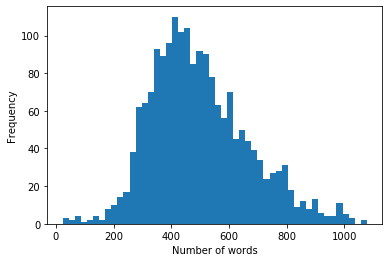

In [12]:
plt.hist(title_lengths,50)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show() 

A maximum sentence length of 800 seems reasonable to cover the majority. Furthermore, we restrict the size of the vocabulary to make the task computationally feasible. 

In [13]:
# Tokenize the text data 
maxlen = 800
# Restrict size of the vocabulary
vocab_size = 15000
restricted_tokenizer = Tokenizer(num_words=vocab_size,lower=True)
restricted_tokenizer.fit_on_texts(texts)
x_restr = restricted_tokenizer.texts_to_sequences(texts)
# Pad the data with zeroes so all samples are of equal length
x_padded = pad_sequences(x_restr,maxlen=maxlen)

# Create a new embedding matrix for the restricted vocabulary ('embedding_matrix' includes the full vocabulary)
trainable_embeddings = np.zeros((vocab_size + 1, 300))    
for i,word in enumerate(list(restricted_tokenizer.word_index.keys())[:vocab_size]):
    trainable_embeddings[i] = embedding_matrix[tokenizer.word_index[word]]


#### Partition into training and test set
The data is partitioned to a training and a test set, where the distribution of labels are respected.

In [14]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), "Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.6110509209100758
Neg labels: 1128 Pos labels: 718
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.5384615384615384
Neg labels: 994 Pos labels: 852
 -----     S&P     -----
Ratio neg labels S&P: 0.5503791982665223
Neg labels: 1016 Pos labels: 830


In [15]:
n_train = 1200
n = len(targets)

np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
part_zeros_1yr = len(zero_indices_1yr) / n
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:round(part_zeros_1yr * n_train)] = zero_indices_1yr[:round(part_zeros_1yr * n_train)]
train_indices_1yr[round(part_zeros_1yr * n_train):] = one_indices_1yr[:round((1 - part_zeros_1yr) * n_train)]
np.random.shuffle(train_indices_1yr)
# All indices not in train is in test. 
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
part_zeros_3yr = len(zero_indices_3yr) / n
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:round(part_zeros_3yr * n_train)] = zero_indices_3yr[:round(part_zeros_3yr * n_train)]
train_indices_3yr[round(part_zeros_3yr * n_train):] = one_indices_3yr[:round((1 - part_zeros_3yr) * n_train)]
np.random.shuffle(train_indices_3yr)
# All indices not in train is in test. 
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
part_zeros_sp = len(zero_indices_sp) / n
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:round(part_zeros_sp * n_train)] = zero_indices_sp[:round(part_zeros_sp * n_train)]
train_indices_sp[round(part_zeros_sp * n_train):] = one_indices_sp[:round((1 - part_zeros_sp) * n_train)]
np.random.shuffle(train_indices_sp)
# All indices not in train is in test. 
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)

x_train_1yr = x[train_indices_1yr]
x_test_1yr = x[test_indices_1yr]
y_train_1yr = targets.iloc[train_indices_1yr]['1 YEAR'].values
y_test_1yr = targets.iloc[test_indices_1yr]['1 YEAR'].values

x_train_3yr = x[train_indices_3yr]
x_test_3yr = x[test_indices_3yr]
y_train_3yr = targets.iloc[train_indices_3yr]['3 YEAR'].values
y_test_3yr = targets.iloc[test_indices_3yr]['3 YEAR'].values

x_train_sp = x[train_indices_sp]
x_test_sp = x[test_indices_sp]
y_train_sp = targets.iloc[train_indices_sp]['S&P'].values
y_test_sp = targets.iloc[test_indices_sp]['S&P'].values

x_train_seq_1yr = x_padded[train_indices_1yr]
x_test_seq_1yr = x_padded[test_indices_1yr]

x_train_seq_3yr = x_padded[train_indices_3yr]
x_test_seq_3yr = x_padded[test_indices_3yr]

x_train_seq_sp = x_padded[train_indices_sp]
x_test_seq_sp = x_padded[test_indices_sp]

# Sanity check of shapes 

print(" ----- 1 YEAR RATE -----")
print("Train data shape (x,y):",x_train_1yr.shape,",", y_train_1yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data shape (x,y):",x_test_1yr.shape,",", y_test_1yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data shape (x,y):",x_train_3yr.shape,",", y_train_3yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data shape (x,y):",x_test_3yr.shape,",", y_test_3yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))
print(" -----     S&P     -----")
print("Train data shape (x,y):",x_train_sp.shape,",", y_train_sp.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data shape (x,y):",x_test_sp.shape,",", y_test_sp.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data shape (x,y): (1200, 300) , (1200,)
Train data label ratio (0 / 1): 733 / 467
Test data shape (x,y): (646, 300) , (646,)
Test data label ratio (0 / 1): 395 / 251
 ----- 3 YEAR RATE -----
Train data shape (x,y): (1200, 300) , (1200,)
Train data label ratio (0 / 1): 646 / 554
Test data shape (x,y): (646, 300) , (646,)
Test data label ratio (0 / 1): 348 / 298
 -----     S&P     -----
Train data shape (x,y): (1200, 300) , (1200,)
Train data label ratio (0 / 1): 660 / 540
Test data shape (x,y): (646, 300) , (646,)
Test data label ratio (0 / 1): 356 / 290


## Models 
The data has been pre-processed and the models can be evaluated. All of the models are fitted with the three data series. 

In [16]:
# Some help functions for plotting the results 

def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs GloVe/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs GloVe/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs GloVe/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

### Logistic Regression with GloVe
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.64      0.89      0.74       395
         1.0       0.54      0.20      0.29       251

    accuracy                           0.62       646
   macro avg       0.59      0.55      0.52       646
weighted avg       0.60      0.62      0.57       646

Test accuracy: 0.6222910216718266


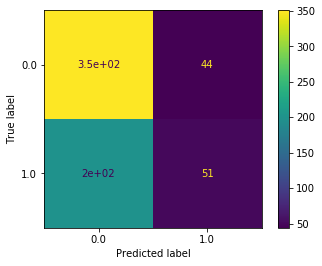

In [17]:
# Logistic regression
logreg_1yr = LogisticRegression(random_state=0).fit(x_train_1yr, y_train_1yr)
plot_results(logreg_1yr,x_test_1yr, y_test_1yr,save=True,name='logreg_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.57      0.71      0.63       348
         1.0       0.53      0.38      0.44       298

    accuracy                           0.56       646
   macro avg       0.55      0.54      0.54       646
weighted avg       0.55      0.56      0.54       646

Test accuracy: 0.5572755417956656


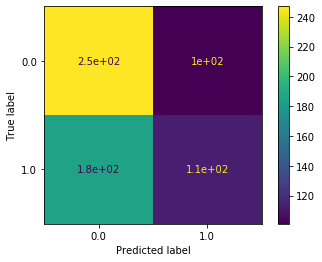

In [18]:
# Logistic regression
logreg_3yr = LogisticRegression(random_state=0).fit(x_train_3yr, y_train_3yr)
plot_results(logreg_3yr,x_test_3yr, y_test_3yr,save=True,name='logreg_3yr')

#### S&P

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

         0.0       0.56      0.86      0.68       356
         1.0       0.51      0.18      0.27       290

    accuracy                           0.56       646
   macro avg       0.54      0.52      0.48       646
weighted avg       0.54      0.56      0.50       646

Test accuracy: 0.5557275541795665


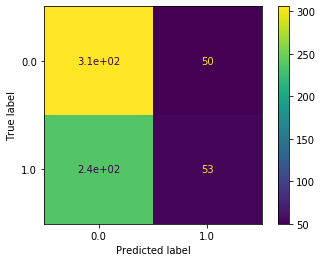

In [19]:
# Logistic regression
logreg_sp = LogisticRegression(random_state=0).fit(x_train_sp, y_train_sp)
plot_results(logreg_sp,x_test_sp, y_test_sp,save=True,name='logreg_sp')

### Support Vector Machine with GloVe
#### 1 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       395
         1.0       0.00      0.00      0.00       251

    accuracy                           0.61       646
   macro avg       0.31      0.50      0.38       646
weighted avg       0.37      0.61      0.46       646

Test accuracy: 0.6114551083591331


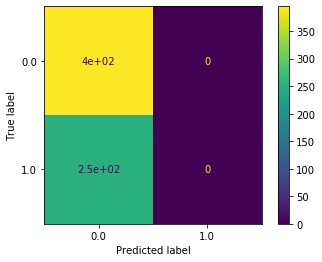

In [20]:
svm_clf_1yr = svm.SVC().fit(x_train_1yr, y_train_1yr)
plot_results(svm_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='svm_1yr')

#### 3 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       348
         1.0       0.00      0.00      0.00       298

    accuracy                           0.54       646
   macro avg       0.27      0.50      0.35       646
weighted avg       0.29      0.54      0.38       646

Test accuracy: 0.5386996904024768


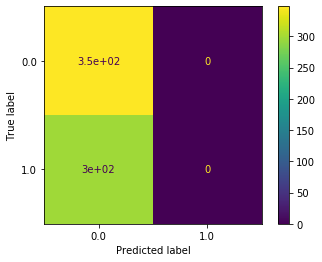

In [21]:
svm_clf_3yr = svm.SVC().fit(x_train_3yr, y_train_3yr)
plot_results(svm_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='svm_3yr')

#### S&P

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       356
         1.0       0.00      0.00      0.00       290

    accuracy                           0.55       646
   macro avg       0.28      0.50      0.36       646
weighted avg       0.30      0.55      0.39       646

Test accuracy: 0.5510835913312694


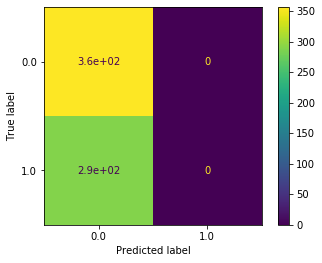

In [22]:
svm_clf_sp = svm.SVC().fit(x_train_sp, y_train_sp)
plot_results(svm_clf_sp, x_test_sp, y_test_sp,save=True,name='svm_sp')

### Random forest with GloVe
#### 1 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.3min finished


Best: 0.588390 using {'max_depth': 50, 'n_estimators': 250}
0.583102 (0.048692) with: {'max_depth': None, 'n_estimators': 250}
0.587951 (0.033740) with: {'max_depth': None, 'n_estimators': 500}
0.573705 (0.045433) with: {'max_depth': None, 'n_estimators': 750}
0.579613 (0.032017) with: {'max_depth': None, 'n_estimators': 1000}
0.588390 (0.036610) with: {'max_depth': 50, 'n_estimators': 250}
0.583119 (0.029248) with: {'max_depth': 50, 'n_estimators': 500}
0.578236 (0.041255) with: {'max_depth': 50, 'n_estimators': 750}
0.572065 (0.027205) with: {'max_depth': 50, 'n_estimators': 1000}
0.561491 (0.028264) with: {'max_depth': 100, 'n_estimators': 250}
0.580941 (0.034314) with: {'max_depth': 100, 'n_estimators': 500}
0.576272 (0.025399) with: {'max_depth': 100, 'n_estimators': 750}
0.585180 (0.037060) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.63      0.86      0.73       395
         1.0       0.47      0.20   

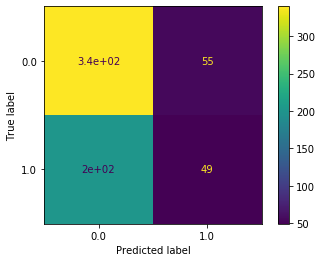

In [23]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_1yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_1yr, y_train_1yr)
plot_results(randomforest_1yr,x_test_1yr, y_test_1yr,save=True,name='rf_1yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### 3 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.2min finished


Best: 0.556667 using {'max_depth': 50, 'n_estimators': 500}
0.534167 (0.029451) with: {'max_depth': None, 'n_estimators': 250}
0.549167 (0.033427) with: {'max_depth': None, 'n_estimators': 500}
0.546667 (0.032532) with: {'max_depth': None, 'n_estimators': 750}
0.555000 (0.028186) with: {'max_depth': None, 'n_estimators': 1000}
0.550000 (0.025820) with: {'max_depth': 50, 'n_estimators': 250}
0.556667 (0.016997) with: {'max_depth': 50, 'n_estimators': 500}
0.543333 (0.040104) with: {'max_depth': 50, 'n_estimators': 750}
0.544167 (0.031413) with: {'max_depth': 50, 'n_estimators': 1000}
0.553333 (0.025874) with: {'max_depth': 100, 'n_estimators': 250}
0.550833 (0.032585) with: {'max_depth': 100, 'n_estimators': 500}
0.553333 (0.025874) with: {'max_depth': 100, 'n_estimators': 750}
0.550833 (0.042728) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.55      0.65      0.60       348
         1.0       0.48      0.37   

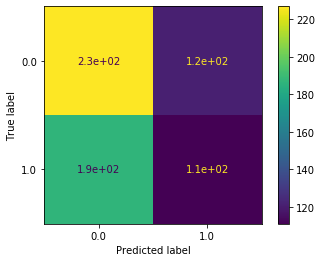

In [24]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='accuracy',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_3yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_3yr, y_train_3yr)
plot_results(randomforest_3yr,x_test_3yr, y_test_3yr,save=True,name='rf_3yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### S&P

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.6min finished


Best: 0.568333 using {'max_depth': 50, 'n_estimators': 1000}
0.556667 (0.035119) with: {'max_depth': None, 'n_estimators': 250}
0.537500 (0.038415) with: {'max_depth': None, 'n_estimators': 500}
0.543333 (0.042295) with: {'max_depth': None, 'n_estimators': 750}
0.563333 (0.040346) with: {'max_depth': None, 'n_estimators': 1000}
0.547500 (0.030516) with: {'max_depth': 50, 'n_estimators': 250}
0.551667 (0.048848) with: {'max_depth': 50, 'n_estimators': 500}
0.550833 (0.032156) with: {'max_depth': 50, 'n_estimators': 750}
0.568333 (0.039405) with: {'max_depth': 50, 'n_estimators': 1000}
0.545000 (0.043970) with: {'max_depth': 100, 'n_estimators': 250}
0.547500 (0.024452) with: {'max_depth': 100, 'n_estimators': 500}
0.550833 (0.033219) with: {'max_depth': 100, 'n_estimators': 750}
0.554167 (0.039660) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.58      0.88      0.70       356
         1.0       0.58      0.21  

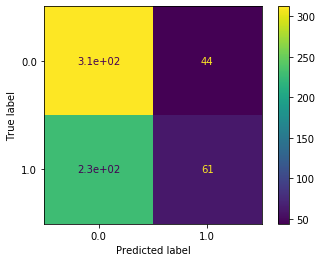

In [25]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='accuracy',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_sp = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_sp, y_train_sp)
plot_results(randomforest_sp,x_test_sp, y_test_sp,save=True,name='rf_sp_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Networks

In [26]:
def create_model(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train_1yr.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_1yr.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

def randomize_params(params, n):
    test_params = []
    for i in range(n):
        temp_par = {}
        while True: 
            for par in params: 
                temp_par.update({par: np.random.choice(params[par])})
            if temp_par not in test_params: 
                test_params.append(temp_par)
                break
    return test_params

### Feed forward, pre-trained embeddings
#### 1 year rate 

In [30]:
n_tests = 50
# Define possible parameters 
possible_params = dict(batch_size = [8, 16, 32],
                       nodes1 = [50, 100, 250, 500],
                       nodes2 = [0, 50, 100, 250, 500], # 0 implies only one hidden layer 
                       dropout_rate = [0.1, 0.3, 0.5],
                       learning_rate = [1e-3, 1e-4, 1e-5],
                       optimizer = ['RMSprop','Adam'])
test_params = randomize_params(possible_params, n_tests)

In [31]:
historylist_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_1yr.append(history)
max_acc_1yr = -1
max_idx_1yr = -1
for i,hist in enumerate(historylist_1yr):
    if max(hist.history['val_acc']) > max_acc_1yr: 
        max_acc_1yr = max(hist.history['val_acc'])
        max_idx_1yr = i
    
print("Best val acc:",max_acc_1yr)
print("For config: ",test_params[max_idx_1yr])


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.63s/it]

Best val acc: 0.6458333
For config:  {'nodes1': 250, 'nodes2': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'batch_size': 32}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 1s 1ms/sample - loss: 0.7045 - acc: 0.5740 - val_loss: 0.6864 - val_acc: 0.5375
Epoch 2/100000
960/960 [==============================] - 0s 139us/sample - loss: 0.6711 - acc: 0.6010 - val_loss: 0.7144 - val_acc: 0.5625
Epoch 3/100000
960/960 [==============================] - 0s 122us/sample - loss: 0.6587 - acc: 0.6240 - val_loss: 0.6598 - val_acc: 0.6250
Epoch 4/100000
960/960 [==============================] - 0s 103us/sample - loss: 0.6534 - acc: 0.6250 - val_loss: 0.6728 - val_acc: 0.5667
Epoch 5/100000
960/960 [==============================] - 0s 138us/sample - loss: 0.6463 - acc: 0.6458 - val_loss: 0.6603 - val_acc: 0.5958
Epoch 6/100000
960/960 [==============================] - 0s 119us/sample - loss: 0.6407 - acc: 0.6510 - val_loss: 0.6547 - val_acc: 0.6417
Epoch 7/100000
960/960 [==============================] - 0s 104us/sample - loss: 0.6427 - acc: 0.6271 - val_loss: 0

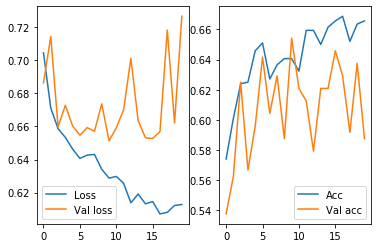

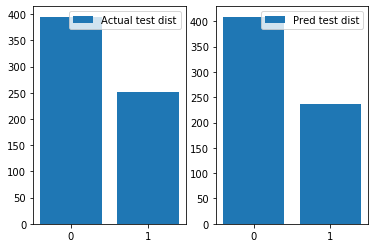

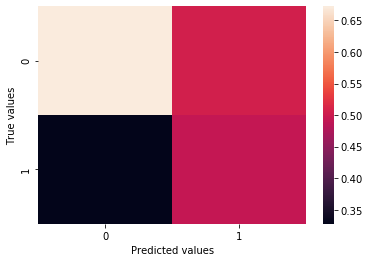

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68       395
         1.0       0.49      0.47      0.48       251

    accuracy                           0.61       646
   macro avg       0.58      0.58      0.58       646
weighted avg       0.60      0.61      0.60       646

Test accuracy: 0.607


In [32]:
bs = test_params[max_idx_1yr].pop('batch_size')
model_ff_1yr = create_model(**test_params[max_idx_1yr])
test_params[max_idx_1yr].update({'batch_size': bs})

history_1yr = model_ff_1yr.fit(x_train_1yr, y_train_1yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_1yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_1yr]['batch_size'],
                                                          test_params[max_idx_1yr]['nodes1'],
                                                          test_params[max_idx_1yr]['nodes2'],
                                                          test_params[max_idx_1yr]['dropout_rate'],
                                                          test_params[max_idx_1yr]['learning_rate'],
                                                          test_params[max_idx_1yr]['optimizer'])
plot_results_nn(history_1yr,model_ff_1yr,x_test_1yr, y_test_1yr,save=True, name=savename_1yr)

### 3 year rate

In [33]:
historylist_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_3yr.append(history)
max_acc_3yr = -1
max_idx_3yr = -1
for i,hist in enumerate(historylist_3yr):
    if max(hist.history['val_acc']) > max_acc_3yr: 
        max_acc_3yr = max(hist.history['val_acc'])
        max_idx_3yr = i
    
print("Best val acc:",max_acc_3yr)
print("For config: ",test_params[max_idx_3yr])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:49<00:00,  6.99s/it]

Best val acc: 0.6125
For config:  {'nodes1': 250, 'nodes2': 50, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'optimizer': 'RMSprop', 'batch_size': 32}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.7128 - acc: 0.5000 - val_loss: 0.6862 - val_acc: 0.5500
Epoch 2/100000
960/960 [==============================] - 0s 232us/sample - loss: 0.7044 - acc: 0.5427 - val_loss: 0.6859 - val_acc: 0.5500
Epoch 3/100000
960/960 [==============================] - 0s 209us/sample - loss: 0.7004 - acc: 0.5250 - val_loss: 0.6853 - val_acc: 0.5500
Epoch 4/100000
960/960 [==============================] - 0s 193us/sample - loss: 0.7043 - acc: 0.5156 - val_loss: 0.6849 - val_acc: 0.5500
Epoch 5/100000
960/960 [==============================] - 0s 209us/sample - loss: 0.6938 - acc: 0.5302 - val_loss: 0.6846 - val_acc: 0.5500
Epoch 6/100000
960/960 [==============================] - 0s 209us/sample - loss: 0.6914 - acc: 0.5375 - val_loss: 0.6844 - val_acc: 0.5583
Epoch 7/100000
960/960 [==============================] - 0s 193us/sample - loss: 0.6901 - acc: 0.5448 - val_loss: 0

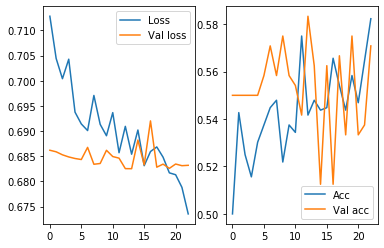

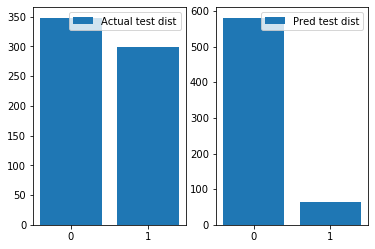

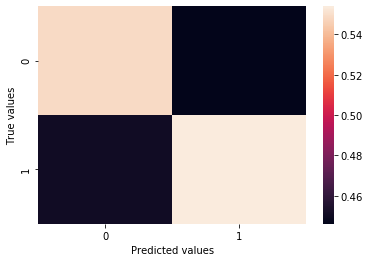

              precision    recall  f1-score   support

         0.0       0.55      0.92      0.69       348
         1.0       0.55      0.12      0.20       298

    accuracy                           0.55       646
   macro avg       0.55      0.52      0.44       646
weighted avg       0.55      0.55      0.46       646

Test accuracy: 0.55


In [34]:
bs = test_params[max_idx_3yr].pop('batch_size')
model_ff_3yr = create_model(**test_params[max_idx_3yr])
test_params[max_idx_3yr].update({'batch_size': bs})

history_3yr = model_ff_3yr.fit(x_train_3yr, y_train_3yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_3yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_3yr]['batch_size'],
                                                          test_params[max_idx_3yr]['nodes1'],
                                                          test_params[max_idx_3yr]['nodes2'],
                                                          test_params[max_idx_3yr]['dropout_rate'],
                                                          test_params[max_idx_3yr]['learning_rate'],
                                                          test_params[max_idx_3yr]['optimizer'])
plot_results_nn(history_3yr,model_ff_3yr,x_test_3yr, y_test_3yr,save=True, name=savename_3yr)


#### S&P

In [35]:
historylist_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_sp.append(history)
max_acc_sp = -1
max_idx_sp = -1
for i,hist in enumerate(historylist_sp):
    if max(hist.history['val_acc']) > max_acc_sp: 
        max_acc_sp = max(hist.history['val_acc'])
        max_idx_sp = i
    
print("Best val acc:",max_acc_sp)
print("For config: ",test_params[max_idx_sp])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:34<00:00, 12.70s/it]

Best val acc: 0.5625
For config:  {'nodes1': 500, 'nodes2': 100, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'optimizer': 'Adam', 'batch_size': 16}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 6s 7ms/sample - loss: 0.6929 - acc: 0.5427 - val_loss: 0.6991 - val_acc: 0.5208
Epoch 2/100000
960/960 [==============================] - 1s 694us/sample - loss: 0.6926 - acc: 0.5365 - val_loss: 0.7063 - val_acc: 0.5208
Epoch 3/100000
960/960 [==============================] - 1s 698us/sample - loss: 0.6930 - acc: 0.5406 - val_loss: 0.7191 - val_acc: 0.5208
Epoch 4/100000
960/960 [==============================] - 1s 708us/sample - loss: 0.6896 - acc: 0.5448 - val_loss: 0.6941 - val_acc: 0.5208
Epoch 5/100000
960/960 [==============================] - 1s 707us/sample - loss: 0.6937 - acc: 0.5396 - val_loss: 0.7143 - val_acc: 0.5208
Epoch 6/100000
960/960 [==============================] - 1s 698us/sample - loss: 0.6802 - acc: 0.5688 - val_loss: 0.7183 - val_acc: 0.5208
Epoch 7/100000
960/960 [==============================] - 1s 698us/sample - loss: 0.6806 - acc: 0.5594 - val_loss: 0

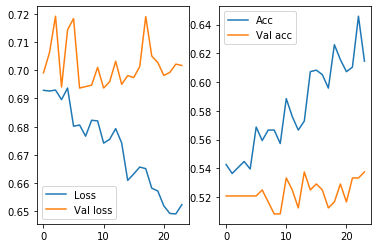

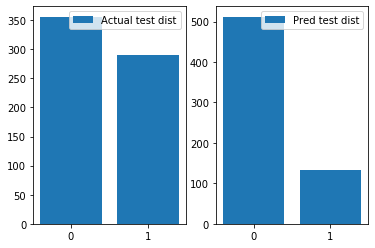

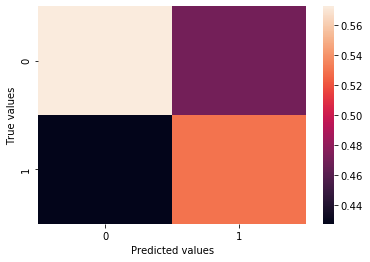

              precision    recall  f1-score   support

         0.0       0.57      0.82      0.68       356
         1.0       0.53      0.24      0.33       290

    accuracy                           0.56       646
   macro avg       0.55      0.53      0.51       646
weighted avg       0.55      0.56      0.52       646

Test accuracy: 0.563


In [36]:
bs = test_params[max_idx_sp].pop('batch_size')
model_ff_sp = create_model(**test_params[max_idx_sp])
test_params[max_idx_sp].update({'batch_size': bs})

history_sp = model_ff_sp.fit(x_train_sp, y_train_sp,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_sp = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_sp]['batch_size'],
                                                          test_params[max_idx_sp]['nodes1'],
                                                          test_params[max_idx_sp]['nodes2'],
                                                          test_params[max_idx_sp]['dropout_rate'],
                                                          test_params[max_idx_sp]['learning_rate'],
                                                          test_params[max_idx_sp]['optimizer'])
plot_results_nn(history_sp,model_ff_sp,x_test_sp, y_test_sp,save=True, name=savename_sp)


### Neural Network - GloVe embeddings as embedded layer
Similar to the previous neural network, but with an embedded layer that is trained together with the weights in the feed-forward network. 

In [37]:
# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero

def merge_output_shape(input_shape):
    return input_shape[0], input_shape[-1]


def create_model_emb_ff(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop',learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                        input_length=maxlen))
    model.add(Lambda(merge_embeddings, output_shape=merge_output_shape))
    if nodes1 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

In [38]:
historylist_emb_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model_emb_ff(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_seq_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_emb_1yr.append(history)
max_acc_emb_1yr = -1
max_idx_emb_1yr = -1
for i,hist in enumerate(historylist_emb_1yr):
    if max(hist.history['val_acc']) > max_acc_emb_1yr: 
        max_acc_emb_1yr = max(hist.history['val_acc'])
        max_idx_emb_1yr = i
    
print("Best val acc:",max_acc_emb_1yr)
print("For config: ",test_params[max_idx_emb_1yr])

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [50:52<00:00, 61.05s/it]

Best val acc: 0.575
For config:  {'nodes1': 500, 'nodes2': 0, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'optimizer': 'Adam', 'batch_size': 8}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 18s 19ms/sample - loss: 0.6677 - acc: 0.6073 - val_loss: 0.6789 - val_acc: 0.5625
Epoch 2/100000
960/960 [==============================] - 8s 9ms/sample - loss: 0.6648 - acc: 0.6198 - val_loss: 0.7083 - val_acc: 0.5625
Epoch 3/100000
960/960 [==============================] - 8s 9ms/sample - loss: 0.6573 - acc: 0.6229 - val_loss: 0.6727 - val_acc: 0.5625
Epoch 4/100000
960/960 [==============================] - 8s 8ms/sample - loss: 0.6477 - acc: 0.6313 - val_loss: 0.6859 - val_acc: 0.5625
Epoch 5/100000
960/960 [==============================] - 9s 9ms/sample - loss: 0.6083 - acc: 0.6562 - val_loss: 0.6623 - val_acc: 0.6208
Epoch 6/100000
960/960 [==============================] - 8s 9ms/sample - loss: 0.5519 - acc: 0.7167 - val_loss: 0.7615 - val_acc: 0.5833
Epoch 7/100000
960/960 [==============================] - 8s 8ms/sample - loss: 0.4192 - acc: 0.8146 - val_loss: 0.7576 - va

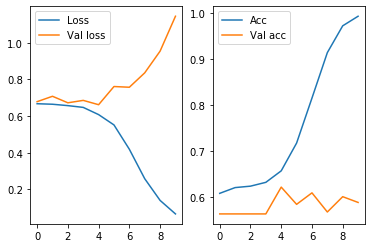

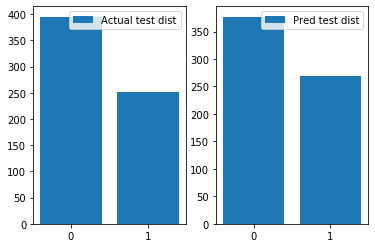

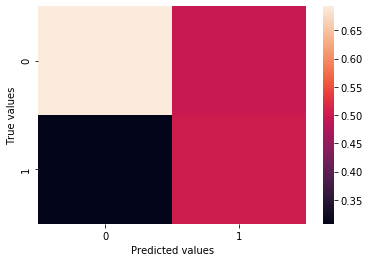

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68       395
         1.0       0.50      0.54      0.52       251

    accuracy                           0.61       646
   macro avg       0.60      0.60      0.60       646
weighted avg       0.62      0.61      0.62       646

Test accuracy: 0.613


In [39]:
bs = test_params[max_idx_emb_1yr].pop('batch_size')
model_emb_1yr = create_model_emb_ff(**test_params[max_idx_emb_1yr])
test_params[max_idx_emb_1yr].update({'batch_size': bs})

history_emb_1yr = model_emb_1yr.fit(x_train_seq_1yr, y_train_1yr,
                                    epochs=100000,
                                    batch_size = bs,
                                    verbose=1,
                                    callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                                    validation_split=0.2)
savename_emb_1yr = "nn_emb_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_emb_1yr]['batch_size'],
                                                              test_params[max_idx_emb_1yr]['nodes1'],
                                                              test_params[max_idx_emb_1yr]['nodes2'],
                                                              test_params[max_idx_emb_1yr]['dropout_rate'],
                                                              test_params[max_idx_emb_1yr]['learning_rate'],
                                                              test_params[max_idx_emb_1yr]['optimizer'])
plot_results_nn(history_emb_1yr,model_emb_1yr,x_test_seq_1yr, y_test_1yr,save=True, name=savename_emb_1yr)

#### 3 year rate

In [40]:
historylist_emb_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model_emb_ff(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_seq_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_emb_3yr.append(history)
max_acc_emb_3yr = -1
max_idx_emb_3yr = -1
for i,hist in enumerate(historylist_emb_3yr):
    if max(hist.history['val_acc']) > max_acc_emb_3yr: 
        max_acc_emb_3yr = max(hist.history['val_acc'])
        max_idx_emb_3yr = i
    
print("Best val acc:",max_acc_emb_3yr)
print("For config: ",test_params[max_idx_emb_3yr])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [48:51<00:00, 58.62s/it]

Best val acc: 0.5541667
For config:  {'nodes1': 250, 'nodes2': 100, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'batch_size': 8}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 19s 19ms/sample - loss: 0.7028 - acc: 0.5125 - val_loss: 0.6902 - val_acc: 0.5500
Epoch 2/100000
960/960 [==============================] - 6s 6ms/sample - loss: 0.6935 - acc: 0.5458 - val_loss: 0.6946 - val_acc: 0.4958
Epoch 3/100000
960/960 [==============================] - 7s 7ms/sample - loss: 0.7009 - acc: 0.5177 - val_loss: 0.6890 - val_acc: 0.5500
Epoch 4/100000
960/960 [==============================] - 7s 7ms/sample - loss: 0.7028 - acc: 0.4948 - val_loss: 0.6991 - val_acc: 0.4500
Epoch 5/100000
960/960 [==============================] - 7s 7ms/sample - loss: 0.6944 - acc: 0.5271 - val_loss: 0.6942 - val_acc: 0.4708
Epoch 6/100000
960/960 [==============================] - 7s 7ms/sample - loss: 0.6877 - acc: 0.5469 - val_loss: 0.6877 - val_acc: 0.5625
Epoch 7/100000
960/960 [==============================] - 7s 7ms/sample - loss: 0.6628 - acc: 0.6083 - val_loss: 0.6850 - va

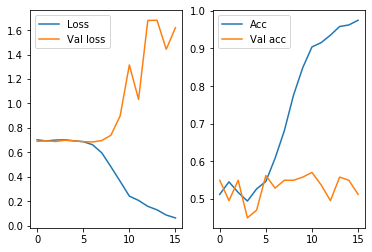

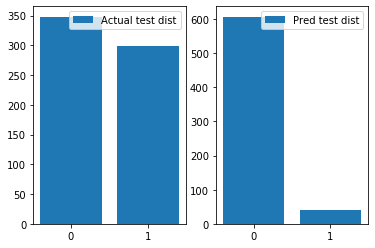

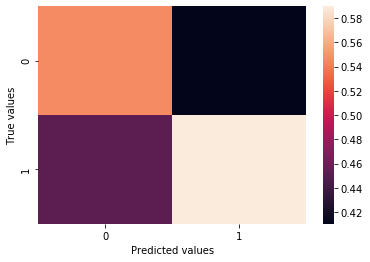

              precision    recall  f1-score   support

         0.0       0.55      0.95      0.70       348
         1.0       0.59      0.08      0.14       298

    accuracy                           0.55       646
   macro avg       0.57      0.52      0.42       646
weighted avg       0.57      0.55      0.44       646

Test accuracy: 0.55


In [41]:
bs = test_params[max_idx_emb_3yr].pop('batch_size')
model_emb_3yr = create_model_emb_ff(**test_params[max_idx_emb_3yr])
test_params[max_idx_emb_3yr].update({'batch_size': bs})

history_emb_3yr = model_emb_3yr.fit(x_train_seq_3yr, y_train_3yr,
                                    epochs=100000,
                                    batch_size = bs,
                                    verbose=1,
                                    callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                                    validation_split=0.2)
savename_emb_3yr = "nn_emb_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_emb_3yr]['batch_size'],
                                                              test_params[max_idx_emb_3yr]['nodes1'],
                                                              test_params[max_idx_emb_3yr]['nodes2'],
                                                              test_params[max_idx_emb_3yr]['dropout_rate'],
                                                              test_params[max_idx_emb_3yr]['learning_rate'],
                                                              test_params[max_idx_emb_3yr]['optimizer'])
plot_results_nn(history_emb_3yr,model_emb_3yr,x_test_seq_3yr, y_test_3yr,save=True, name=savename_emb_3yr)

#### S&P

In [42]:
historylist_emb_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model_emb_ff(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_seq_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_emb_sp.append(history)
max_acc_emb_sp = -1
max_idx_emb_sp = -1
for i,hist in enumerate(historylist_emb_sp):
    if max(hist.history['val_acc']) > max_acc_emb_sp: 
        max_acc_emb_sp = max(hist.history['val_acc'])
        max_idx_emb_sp = i
    
print("Best val acc:",max_acc_emb_sp)
print("For config: ",test_params[max_idx_emb_sp])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [57:32<00:00, 69.05s/it]

Best val acc: 0.52916664
For config:  {'nodes1': 100, 'nodes2': 250, 'dropout_rate': 0.1, 'learning_rate': 1e-05, 'optimizer': 'Adam', 'batch_size': 32}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 19s 20ms/sample - loss: 0.6939 - acc: 0.4490 - val_loss: 0.6933 - val_acc: 0.4792
Epoch 2/100000
960/960 [==============================] - 2s 2ms/sample - loss: 0.6933 - acc: 0.4802 - val_loss: 0.6930 - val_acc: 0.5292
Epoch 3/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.6926 - acc: 0.5469 - val_loss: 0.6929 - val_acc: 0.5208
Epoch 4/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.6922 - acc: 0.5552 - val_loss: 0.6928 - val_acc: 0.5208
Epoch 5/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.6919 - acc: 0.5573 - val_loss: 0.6925 - val_acc: 0.5208
Epoch 6/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.6913 - acc: 0.5573 - val_loss: 0.6926 - val_acc: 0.5208
Epoch 7/100000
960/960 [==============================] - 10s 11ms/sample - loss: 0.6909 - acc: 0.5573 - val_loss: 0.6924 - 

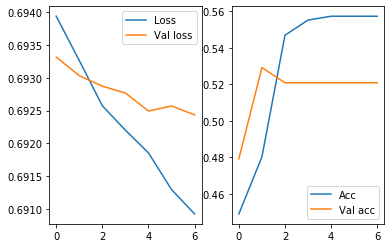

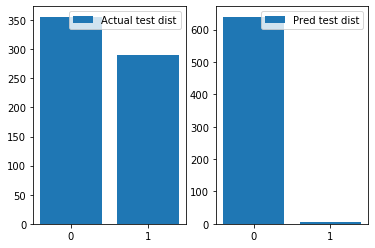

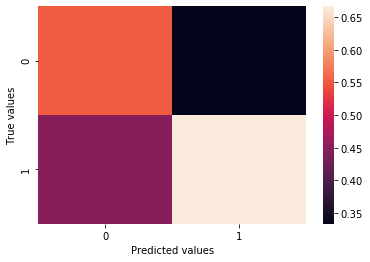

              precision    recall  f1-score   support

         0.0       0.55      0.99      0.71       356
         1.0       0.67      0.01      0.03       290

    accuracy                           0.55       646
   macro avg       0.61      0.50      0.37       646
weighted avg       0.60      0.55      0.40       646

Test accuracy: 0.554


In [43]:
bs = test_params[max_idx_emb_sp].pop('batch_size')
model_emb_sp = create_model_emb_ff(**test_params[max_idx_emb_sp])
test_params[max_idx_emb_sp].update({'batch_size': bs})

history_emb_sp = model_emb_sp.fit(x_train_seq_sp, y_train_sp,
                                    epochs=100000,
                                    batch_size = bs,
                                    verbose=1,
                                    callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                                    validation_split=0.2)
savename_emb_sp = "nn_emb_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_emb_sp]['batch_size'],
                                                              test_params[max_idx_emb_sp]['nodes1'],
                                                              test_params[max_idx_emb_sp]['nodes2'],
                                                              test_params[max_idx_emb_sp]['dropout_rate'],
                                                              test_params[max_idx_emb_sp]['learning_rate'],
                                                              test_params[max_idx_emb_sp]['optimizer'])
plot_results_nn(history_emb_sp,model_emb_sp,x_test_seq_sp, y_test_sp,save=True, name=savename_emb_sp)

### Neural Network - GloVe embeddings and Bidirectional LSTM
The same embeddings as in the previous model, but with a bidirectional LSTM rather than a multi layer perceptron at the top.

In [44]:
def create_model_lstm(nodes=128, dropout_rate=0.3, recurrent_dropout=0.3, optimizer='rmsprop',learning_rate=0.001):
    if optimizer == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                        input_length=maxlen))
    model.add(Bidirectional(LSTM(nodes, recurrent_dropout=recurrent_dropout)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

#### 1 year rate

In [45]:
earlystop_lstm = EarlyStopping(monitor='val_acc',
                               patience=4,
                               restore_best_weights=True)

lstm_1yr_mod = create_model_lstm() 
lstm_1yr_hist = lstm_1yr_mod.fit(x_train_seq_1yr, y_train_1yr,
                                 epochs=1000,
                                 validation_split=0.2, 
                                 verbose=1,
                                 batch_size=64,
                                 callbacks=[earlystop_lstm])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 2570s 3s/sample - loss: 0.6816 - acc: 0.5958 - val_loss: 0.6949 - val_acc: 0.5625
Epoch 2/1000
960/960 [==============================] - 2394s 2s/sample - loss: 0.6159 - acc: 0.6792 - val_loss: 0.7814 - val_acc: 0.5625
Epoch 3/1000
960/960 [==============================] - 2371s 2s/sample - loss: 0.5698 - acc: 0.7042 - val_loss: 0.6902 - val_acc: 0.5333
Epoch 4/1000
960/960 [==============================] - 2226s 2s/sample - loss: 0.4974 - acc: 0.7750 - val_loss: 0.7888 - val_acc: 0.5708
Epoch 5/1000
960/960 [==========================

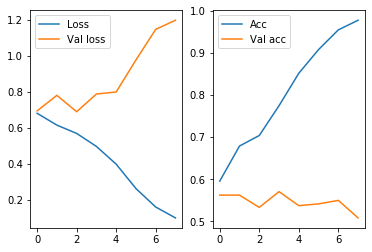

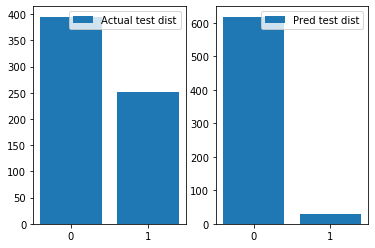

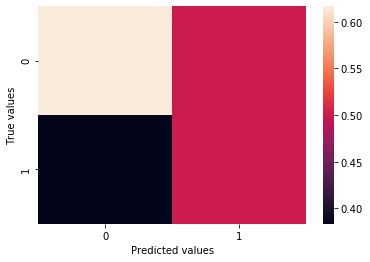

              precision    recall  f1-score   support

         0.0       0.62      0.96      0.75       395
         1.0       0.50      0.06      0.10       251

    accuracy                           0.61       646
   macro avg       0.56      0.51      0.43       646
weighted avg       0.57      0.61      0.50       646

Test accuracy: 0.611


In [46]:
plot_results_nn(lstm_1yr_hist,lstm_1yr_mod,x_test_seq_1yr, y_test_1yr,save=True, name="lstm_1yr")

In [47]:
lstm_3yr_mod = create_model_lstm() 
lstm_3yr_hist = lstm_3yr_mod.fit(x_train_seq_3yr, y_train_3yr,
                                 epochs=1000,
                                 validation_split=0.2, 
                                 verbose=1,
                                 batch_size=64,
                                 callbacks=[earlystop_lstm])

Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 3076s 3s/sample - loss: 0.7152 - acc: 0.5083 - val_loss: 0.7116 - val_acc: 0.4583
Epoch 2/1000
960/960 [==============================] - 3003s 3s/sample - loss: 0.6513 - acc: 0.6250 - val_loss: 0.7219 - val_acc: 0.4958
Epoch 3/1000
960/960 [==============================] - 3660s 4s/sample - loss: 0.6037 - acc: 0.6885 - val_loss: 0.7079 - val_acc: 0.5375
Epoch 4/1000
960/960 [==============================] - 2795s 3s/sample - loss: 0.5251 - acc: 0.7854 - val_loss: 0.7417 - val_acc: 0.5292
Epoch 5/1000
960/960 [==============================] - 4819s 5s/sample - loss: 0.4104 - acc: 0.8510 - val_loss: 0.8178 - val_acc: 0.5208
Epoch 6/1000
960/960 [==============================] - 2517s 3s/sample - loss: 0.2819 - acc: 0.9031 - val_loss: 0.9009 - val_acc: 0.5208
Epoch 7/1000
960/960 [==============================] - 2545s 3s/sample - loss: 0.1826 - acc: 0.9521 - val_loss: 1.0980 - val_

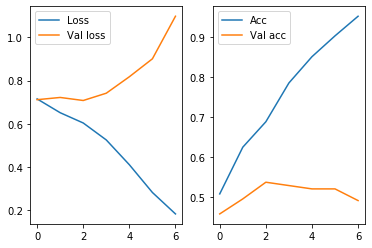

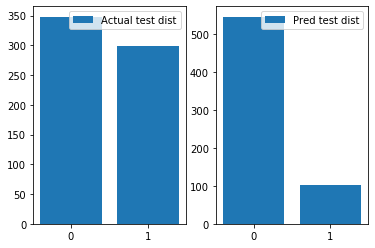

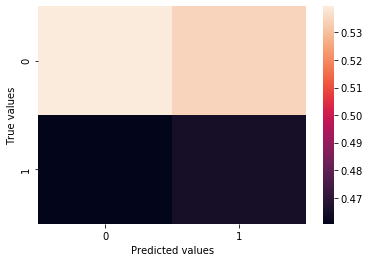

              precision    recall  f1-score   support

         0.0       0.54      0.84      0.66       348
         1.0       0.47      0.16      0.24       298

    accuracy                           0.53       646
   macro avg       0.50      0.50      0.45       646
weighted avg       0.51      0.53      0.46       646

Test accuracy: 0.528


In [48]:
plot_results_nn(lstm_3yr_hist,lstm_3yr_mod,x_test_seq_3yr, y_test_3yr,save=True, name="lstm_3yr")

In [49]:
lstm_sp_mod = create_model_lstm() 
lstm_sp_hist = lstm_sp_mod.fit(x_train_seq_sp, y_train_sp,
                                 epochs=1000,
                                 validation_split=0.2, 
                                 verbose=1,
                                 batch_size=64,
                                 callbacks=[earlystop_lstm])

Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 2678s 3s/sample - loss: 0.7073 - acc: 0.5406 - val_loss: 0.7067 - val_acc: 0.5167
Epoch 2/1000
960/960 [==============================] - 2579s 3s/sample - loss: 0.6508 - acc: 0.6198 - val_loss: 0.7177 - val_acc: 0.5250
Epoch 3/1000
960/960 [==============================] - 2592s 3s/sample - loss: 0.6014 - acc: 0.7021 - val_loss: 0.7385 - val_acc: 0.5083
Epoch 4/1000
960/960 [==============================] - 2604s 3s/sample - loss: 0.5160 - acc: 0.7875 - val_loss: 0.8614 - val_acc: 0.5083
Epoch 5/1000
960/960 [==============================] - 2679s 3s/sample - loss: 0.3832 - acc: 0.8656 - val_loss: 1.1243 - val_acc: 0.4625
Epoch 6/1000
960/960 [==============================] - 2703s 3s/sample - loss: 0.2803 - acc: 0.9021 - val_loss: 0.9256 - val_acc: 0.5000


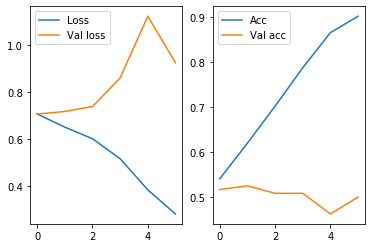

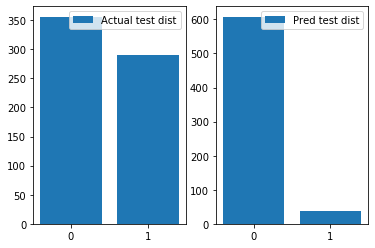

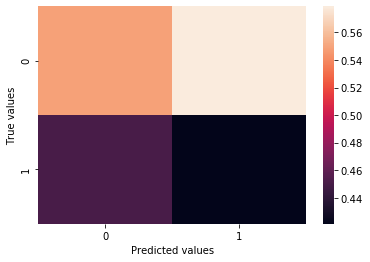

              precision    recall  f1-score   support

         0.0       0.55      0.94      0.69       356
         1.0       0.42      0.06      0.10       290

    accuracy                           0.54       646
   macro avg       0.49      0.50      0.40       646
weighted avg       0.49      0.54      0.43       646

Test accuracy: 0.542


In [50]:
plot_results_nn(lstm_sp_hist,lstm_sp_mod,x_test_seq_sp, y_test_sp,save=True, name="lstm_sp")

## Results

The following results were achieved on the independent test set on the IMDB dataset. Pre-trained GloVe-embeddings were used and 

| Model |  Test Accuracy (%) | Hyperparameters |
| :----- | --------------- | --- | 
| Random Classifier | 50.3 | N/A |
| Logistic Regression | 85.2  | N/A |
| Linear Discriminant Analysis | 85.3  | N/A |
| Support Vector Machine | 84.1 | N/A |
| Random Forest | 80.9  | n_estimators=5000, max_depth=50 |
| XGBoost | __86.1__ | n_estimators=500 |
| Multi Layer Perceptron (Pre-trained) | 85.2 | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |
| Multi Layer Perceptron (Cont. training) |  | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |
| LSTM | | n_lstm1=20, n_lstm2=20, nodes=50,dropout_rate=0.3 | 

XGBoost gives the best performance on the test set when using GloVe-embeddings. The LSTM-approach takes a lot longer to train, and it is therefore harder to conduct a decent hyperparameter search. The LSTM is the only approach that takes the order of the words into account, which could potentially give a better performance if optimized well.

For comparison, the table below displays state-of-the-art models for the IMDB classification task. 

| Model |	Accuracy (%) |	Paper / Source|
|:----- | ---------- | -------------- |  
| XLNet (Yang et al., 2019) |	__96.21__ |	XLNet: Generalized Autoregressive Pretraining for Language Understanding|
| BERT_large+ITPT (Sun et al., 2019) 	|95.79 |	How to Fine-Tune BERT for Text Classification?|
| BERT_base+ITPT (Sun et al., 2019) |	95.63 |	How to Fine-Tune BERT for Text Classification?|
| ULMFiT (Howard and Ruder, 2018) |	95.4 |	Universal Language Model Fine-tuning for Text Classification|
| Block-sparse LSTM (Gray et al., 2017) |	94.99 |	GPU Kernels for Block-Sparse Weights|
| oh-LSTM (Johnson and Zhang, 2016)| 	94.1| 	Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings |
| Virtual adversarial training (Miyato et al., 2016) |	94.1 	|Adversarial Training Methods for Semi-Supervised Text Classification |
| BCN+Char+CoVe (McCann et al., 2017) |	91.8 |	Learned in Translation: Contextualized Word Vectors |

